## ECE495 Lab2: Krichmar Path Planning using Nengo

This Lab uses Nengo to find the optimal path of a square or rectangular map using Krichmar's spike-wave propagation algorithm. The objectives of this lab are to:
- Implement Krichmar's spike-wave propagation algorithm using Nengo neurons
- Ensure the spike wave works for any rectangular or square map
- Utilize an "off-chip" AER to compute the fastest route to get from any starting point (location) to any ending point (location)

_Note: This is your assignment description and a proposed outline by which you can complete your assignment_
- The assignment is worth 60 points
- You may hardcode your connections for each of the three required maps _for a max score of 50/60_
- _**Be sure to print your final path for each map or save it somewhere in your repository so that I can check your work!**_

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [175]:
import matplotlib.pyplot as plt
import numpy as np

import nengo

import array as arr
from nengo.dists import Uniform
from nengo.utils.matplotlib import rasterplot
from nengo.processes import Piecewise

### Input Maps

Check that your spike-wave propagation and AER work for these three maps:
 
(a) The following $3 \times 3$ array with start location 0 (top left) and end location 8 (bottom right). 
$$\begin{bmatrix} 1 & 2 & 1 \\
                  1 & 3 & 5 \\
                  7 & 1 & 1
                      \end{bmatrix}$$

(b) The following $3 \times 4$ array with start location 0 and end location 11.
$$\begin{bmatrix} 1 & 2 & 1 & 6 \\
                  1 & 3 & 5 & 3 \\
                  7 & 1 & 4 & 1
                      \end{bmatrix}$$

(c) The following $5 \times 5$ array with start location 10 and end location 4.
$$\begin{bmatrix} 1 & 3 & 7 & 2 & 1\\
                  3 & 1 & 5 & 3 & 1\\
                  3 & 2 & 6 & 1 & 2\\
                  3 & 1 & 5 & 6 & 1\\
                  2 & 2 & 1 & 1 & 2
                      \end{bmatrix}$$


In [176]:
# three maps that are given for this scenario
map1 = np.array([[1, 2, 1], [1, 3, 5], [7, 1, 1]])
map2 = np.array([[1, 2, 1, 6], [1, 3, 5, 3], [7, 1, 4, 1]])
map3 = np.array(
    [
        [1, 3, 7, 2, 1],
        [3, 1, 5, 3, 1],
        [3, 2, 6, 1, 2],
        [3, 1, 5, 6, 1],
        [2, 2, 1, 1, 2],
    ]
)
desired_map = map1
map_size = desired_map.size
# gets num rows and num cols
num_rows, num_cols = desired_map.shape


# class that has info on initial location and the neighbors
class Block:
    def __init__(self, initial_loc):
        self.initial_loc = initial_loc
        self.neighbors = []


neuron_info = []
for i in range(num_rows):
    rows = []
    for j in range(num_cols):
        rows.append(Block((i, j)))
    neuron_info.append(rows)

for i in range(num_rows):
    for j in range(num_cols):
        # checks if is a corner, then edge, then knows it's in the middle and adds everything around it
        connections = []
        # top L corner
        if (i == 0) and (j == 0):
            connections.append([i + 1, j])
            connections.append([i, j + 1])
            connections.append([i + 1, j + 1])
        # top R corner
        elif (i == 0) and (j + 1 == num_cols):
            connections.append([i, j - 1])
            connections.append([i + 1, j])
            connections.append([i + 1, j - 1])

        # bottom L corner
        elif (i + 1 == num_rows) and (j == 0):
            connections.append([i - 1, j])
            connections.append([i, j + 1])
            connections.append([i - 1, j + 1])
        # bottom R corner
        elif (i + 1 == num_rows) and (j + 1 == num_cols):
            connections.append([i - 1, j])
            connections.append([i, j - 1])
            connections.append([i - 1, j - 1])
        # top edge
        elif i == 0:
            connections.append([i, j - 1])
            connections.append([i + 1, j])
            connections.append([i, j + 1])
            connections.append([i + 1, j - 1])
            connections.append([i + 1, j + 1])
        # bottom edge
        elif i + 1 == num_rows:
            connections.append([i - 1, j])
            connections.append([i, j - 1])
            connections.append([i, j + 1])
            connections.append([i - 1, j + 1])
            connections.append([i - 1, j - 1])
        # left edge
        elif j == 0:
            connections.append([i - 1, j])
            connections.append([i + 1, j])
            connections.append([i, j + 1])
            connections.append([i - 1, j + 1])
            connections.append([i + 1, j + 1])
        # right edge
        elif j + 1 == num_cols:
            connections.append([i - 1, j])
            connections.append([i, j - 1])
            connections.append([i + 1, j])
            connections.append([i + 1, j - 1])
            connections.append([i - 1, j - 1])
        # is somewhere in the middle and has all 8 neighbors
        else:
            connections.append([i - 1, j])
            connections.append([i, j - 1])
            connections.append([i + 1, j])
            connections.append([i, j + 1])
            connections.append([i - 1, j + 1])
            connections.append([i + 1, j - 1])
            connections.append([i + 1, j + 1])
            connections.append([i - 1, j - 1])
        neuron_info[i][j].neighbors = connections


# print(neuron_info[0][0].neighbors)
# for i in range(num_rows):
#     for j in range(num_cols):
#         print(neuron_info[i][j].initial_loc)
#         print(neuron_info[i][j].neighbors)

### Set up and run your Nengo model to implement the spike-wave propagation
_Be sure to generalize or take the 10 points deduction!_

Hints: 
- Use a piecewise function to kick off the spike wave, then turn off your input and let the wave do the rest. Be sure this input connects to your _start location._
- Use a Nengo Ensemble for each map location (you can use an Ensemble array, a multidimensional ensemble, or a list of ensembles). Every map location has anywhere from 3 (corner locations) to 8 (inside locations) neighbors to which it can send a spike. Be careful with your connections! I personally said each of them had 8 possible locations and then deleted any locations that were "off-map", but do what makes the most sense to you. DONE!!!
- Create a delay node to emulate an axonal delay from Krichmar's algorithm. Each map location should have a delay equal to the weight (difficulty of traversal) of the location.
- Implementing inhibition is _difficult_! Recall from Krichmar's algorithm that once a map location fires, it should not fire again. If you can't get the inhibition to work, instead try to add another function to your delay node that turns off a map location once it's sent the spike wave forward

In [177]:
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))
        self.started_spiking = False
        self.finished_spiking = False

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        # computes inhibition
        if self.history[0] > 0.8:
            self.started_spiking = True
        if self.started_spiking == True:
            if self.history[0] < 0.25:
                self.finished_spiking = True
        if self.finished_spiking == True:
            return 0
        else:
            return self.history[0]


model = nengo.Network(label="Krichmar's Path Planning")
with model:

    neuron_list = []
    for i in range(num_rows):  # i goes from 0-> size-1
        row = []
        for j in range(num_cols):
            row.append(nengo.Ensemble(100, dimensions=1))
        neuron_list.append(row)

    dt = 0.001  # default nengo timestep
    delay_nodes = []
    inp_node = nengo.Node(
        Piecewise({0: 0, 1: 1, 1.25: 0, 2: 1})
    )  # quick spike into start node

    for i in range(num_rows):
        rows = []
        for j in range(num_cols):
            time_delay = desired_map[i][
                j
            ]  # seconds by which you wish to delay the signal
            delay = Delay(1, timesteps=int(time_delay / dt))
            rows.append(nengo.Node(delay.step, size_in=1, size_out=1))
        delay_nodes.append(rows)

    nengo.Connection(inp_node, delay_nodes[0][0])

    for i in range(num_rows):
        for j in range(num_cols):
            nengo.Connection(delay_nodes[i][j], neuron_list[i][j])
            for neighbor in neuron_info[i][j].neighbors:
                # print(neighbor)
                nengo.Connection(
                    neuron_list[i][j], delay_nodes[neighbor[0]][neighbor[1]]
                )

    delay_probe = []
    neuron_probe = []
    for i in range(num_rows):
        rows = []
        neuron_row = []
        for j in range(num_cols):
            rows.append(nengo.Probe(delay_nodes[i][j], synapse=0.01))
            neuron_row.append(nengo.Probe(neuron_list[i][j], synapse=0.01))
        delay_probe.append(rows)
        neuron_probe.append(neuron_row)

with nengo.Simulator(model) as sim:
    sim.run(12)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

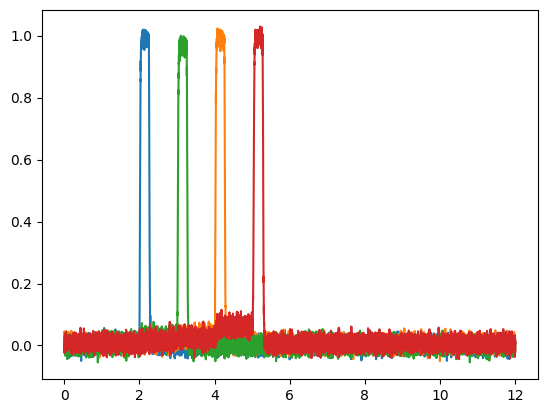

In [178]:
plt.figure()
# plt.plot(sim.trange(), sim.data[delay_probe[0][0]])
plt.plot(sim.trange(), sim.data[neuron_probe[0][0]])
plt.plot(sim.trange(), sim.data[neuron_probe[0][1]])
plt.plot(sim.trange(), sim.data[neuron_probe[1][0]])
plt.plot(sim.trange(), sim.data[neuron_probe[2][2]])


plt.xlabel = "time(x)"
plt.ylabel = "neuron height"  #

### Create AER off-neuron
_Pay attention to how Krichmar says he uses the AER to determine the path_  

Hints:
- The AER contains a location and a time of first spike.
- Start at the end location and work backward!
- I found that by looking at the first spike times of all possible neighboring map locations and choosing the smallest time allowed me to work from end node to start node for my optimal path.

In [189]:
# checks first spike for all locations in map
aer_spike = []
for i in range(num_rows):
    rows = []
    for j in range(num_cols):
        aer = sim.data[neuron_probe[i][j]] > 0.25
        spike_loc = np.where(aer == True)
        first_spike = spike_loc[0][0]
        # print(first_spike)
        rows.append(first_spike)
    aer_spike.append(rows)

# will need to change based off desired map
final_loc = neuron_info[2][2]
start_loc = neuron_info[0][0]
# print(final_loc1.initial_loc)
curr_loc = final_loc
shortest_path = []
shortest_path.append(final_loc.initial_loc)
while curr_loc != start_loc:
    curr_min = 1000000
    next_loc = None
    # print(curr_loc.neighbors)
    for neighbor in curr_loc.neighbors:
        # print(neighbor)
        if aer_spike[neighbor[0]][neighbor[1]] < curr_min:
            # print(aer_spike[neighbor[0]][neighbor[1]])
            curr_min = aer_spike[neighbor[0]][neighbor[1]]
            next_loc = neighbor
    shortest_path.append(next_loc)
    curr_loc = next_loc

# print(start_loc1.initial_loc)
shortest_path.append(start_loc.initial_loc)
# shortest_path= shortest_path.reverse()

AttributeError: 'list' object has no attribute 'neighbors'

### Print your optimal path
_Be sure to show your results_  

Some options:
- You can print your map locations as x- and y- coordinates (examples: start_loc = [0,0] or [2,0]) or flattened locations (examples: start_loc = 0 or 10)
- You can create a picture of a map (like in Krichmar's paper) where you draw out your final path

In [186]:
print(shortest_path)

[(2, 2), [2, 1]]
